# AUC MAP

In [66]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
import sklearn.metrics as metrics

from os import path
import tqdm

from training_bert import BertNliLight
from custom_data_set import SnliDataset
from custom_data_set import test_dir
from torch.utils.data import DataLoader

from attention_algorithms.raw_attention import RawAttention

from attention_algorithms.raw_attention import normalize_attention
from attention_algorithms.raw_attention import hightlight_txt

from IPython.display import display, HTML

# set the repository to the git repository
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "stage_4_gm":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(">> the git rep : ", end="")
print(os.getcwd())

# the folder where we will save our data
plots_folder = os.path.join(os.getcwd(), '.cache', 'plots')
graph_folder = path.join(plots_folder, "auc_head_map")
if not path.exists(path.join(plots_folder, "auc_head_map")):
    os.mkdir(path.join(plots_folder, "auc_head_map"))

print(f">> the plots location : {graph_folder}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
>> the git rep : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm
>> the plots location : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm\.cache\plots\auc_head_map


In [19]:
# load the model

ckp = path.join(".cache", "logs", "igrida_trained", "0", "best.ckpt")
model = BertNliLight.load_from_checkpoint(ckp)
model.eval()  # make sure to have the model in eval mod before using it

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertNliLight(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [35]:
# load the data
# load some data just load one sentence
data_set = SnliDataset(dir=test_dir, nb_sentences=1000, msg=False)
data_loader = DataLoader(data_set, batch_size=1000, shuffle=False)

sentences, masks, train_labels = next(iter(data_loader))

print(f">> shape of the sentences : {sentences.shape}")
print(f">> shape of the masks : {masks.shape}")

>> shape of the sentences : torch.Size([1000, 150])
>> shape of the masks : torch.Size([1000, 150])


In [36]:
# the data we annotated.
e_snli_data = pd.read_csv(os.path.join('.cache', 'raw_data', 'e_snli', 'cleaned_data', 'test.csv'), sep=",")\
    [["tok_sent", "hg_goal"]]
e_snli_data.head()

,tok_sent,hg_goal
0,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,"['[CLS]', 'a', 'woman', 'with', 'a', 'green', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"['[CLS]', 'a', 'woman', 'with', 'a', 'green', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## The AUC Map

---

The objectiv here is for each head $h$ of each layer $l$ to have the information wether or not it will provide a plausible explanation. We want to study each head sepratly to see if some heads are usefull and thus prune the useless heads.

As a reminder, for each sentence we have a matrix $head_{l,h} \in [0,1]^{T\times T}$ This is the attention. Because it is the attention we have the following property :
$$
\sum_{j=0}^{T-1}\quad head_{l,h}[i,j] = 1 \quad \quad \forall i \in \{0,\dots, T-1\}
$$

Then for every token $j$ in our sentence we will compute the attention score for this token as :
$$
a_{h,l}^j = \sum_{i=0}^{T-1}\quad head_{l,h}[i,j]\quad \quad \forall j \in \{0,1,\dots,T-1\}
$$



In [38]:
class LenException(Exception):
    pass

SPECIAL_TOKENS = ["[CLS]", "[SEP]", "[PAD]"]

Y_test = []

nb_err = 0

# where we
pur_attention = {}

for i in range(12):
    pur_attention[f"layer_{i}"] = {}
    for j in range(12):
        pur_attention[f"layer_{i}"][f"head_{j}"] = []


for _, i in enumerate(tqdm.tqdm(range(1000))):
    j = 0
    # iteration through all the sentences
    # construct the raw attention object
    sent = sentences[i, :].clone().detach()[None,:]
    mk = masks[i, :].clone().detach()[None,:]
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )

    # find the e-snli sentence that corresponds to our problem
    try :
        while j<e_snli_data.shape[0] and raw_attention_inst.tokens!=eval(e_snli_data["tok_sent"][j]):
            j+=1

        if j>=e_snli_data.shape[0]:
            raise LenException

        if raw_attention_inst.tokens!=eval(e_snli_data["tok_sent"][j]):
            raise LenException

        else :
            # once the sentence is found >> add the e-snli annotation
            Y_test += eval(e_snli_data["hg_goal"][j])

            # loop over every head of every layer
            for l in range(12):
                for h in range(12):
                    mat = raw_attention_inst.attention_tensor[0, l ,h, :, :]

                    # make the sum on the column >> agregation of the weights
                    # >> dim=0 >> we reduce the number of lines
                    b = mat.sum(dim=0)

                    # >> remove the special tokens
                    # >> normalize the attention
                    b = normalize_attention(raw_attention_inst.tokens, b)

                    # >> add the attention
                    pur_attention[f"layer_{l}"][f"head_{h}"] += list(b.detach().numpy())




    except LenException :
        # count the different errors
        nb_err += 1


# >> the errors are for the sentences we didn't found in the snli dataset
print(f">> nb_errors : {nb_err}")

# how many labeled example do we have
print(f">> len Y_test : {len(Y_test)}")

100%|██████████| 1000/1000 [03:49<00:00,  4.37it/s]

>> nb_errors 21
>> len Y_test 26600


TODO : explanation of how the AUC map is constructed

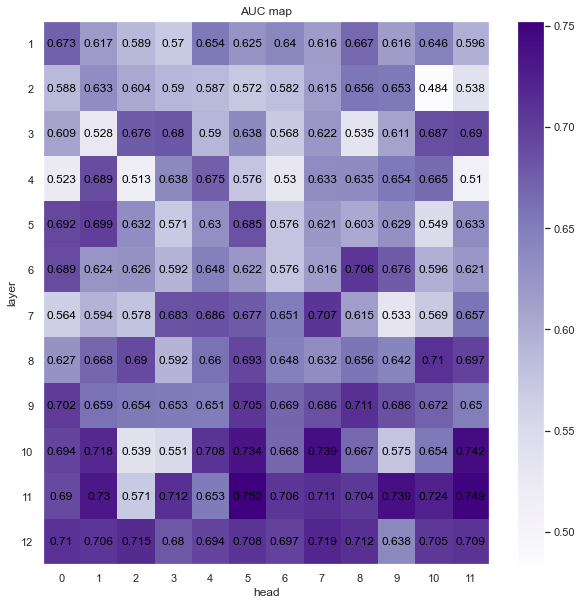

In [45]:
# Construction of the AUC map
auc_map = np.zeros((12,12))
for l in range(12):
    for h in range(12):
        preds = pur_attention[f"layer_{l}"][f"head_{h}"]
        fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
        auc_map[l,h] = metrics.auc(fpr, tpr)

# plot the color map
fig = plt.figure(figsize=(10, 10))
plt.imshow(auc_map, aspect='auto', cmap='Purples')
plt.title("AUC map")
plt.xlabel('head')
plt.ylabel('layer')
ax = plt.gca()
y_label_list = [str(i + 1) for i in range(auc_map.shape[0])]
x_label_list = [str(i) for i in range(auc_map.shape[1])]

ax.set_xticks(range(auc_map.shape[1]))
ax.set_yticks(range(auc_map.shape[0]))

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

for x_index in range(auc_map.shape[1]):
    for y_index in range(auc_map.shape[0]):
        label = str(np.round(auc_map[y_index, x_index], 3))
        ax.text(x_index, y_index, label, color='black', ha='center', va='center')

plt.grid()
plt.colorbar()
plt.savefig(os.path.join(graph_folder,"auc_map.png"))
plt.show()

We can make here some really interesting comments :

- first the maximum value for the *AUC* on this map is $\approx 0.75$. This is a really high *plausibility score*. The *AUC* provided here is much better than the *AUC* provided by the flow max problem
- for every head of every layer we have an *AUC* greater than $0.5$ this means that every layer provide a plausible explanation (better than a random explanation).
- the heads with an AUC near $0.5$ provide a useless information. $0.5$ is the worst AUC we can obtain.
- we will retain the head 5 of the layer 11. Then to access the best head we will do attention_tensor[0,10,5], the heads are numbered from 0 to 11 but the layers are numbered from 1 to 12 because in the transformers architecture the layer 0 is the non-contextual embedding layer (that we do not study here).

## HTML visualisation

---

We will look at the highlighted words and compare it with the e-snli annotation.

In [74]:
import random
sent_choice = random.randint(0,1000)
print(f">> we will look at the sentence : {sent_choice}")

>> we will look at the sentence : 896


In [75]:
# visualize on the best head

try :
    sent = sentences[sent_choice, :].clone().detach()[None,:]
    mk = masks[sent_choice, :].clone().detach()[None,:]
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )

    # construction of the attention score
    attention_score = raw_attention_inst.attention_tensor[0,10,5,:,:].sum(dim=0)

    # attention visu
    vis = hightlight_txt(raw_attention_inst.tokens, attention_score, torch.tensor(eval(e_snli_data["hg_goal"][sent_choice])))
    display(HTML(vis))

except Exception :
    print("sentences problems")

In [76]:
try :
    sent = sentences[sent_choice, :].clone().detach()[None,:]
    mk = masks[sent_choice, :].clone().detach()[None,:]
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )

    # construction of the attention score >> here we take the layer 4 and the head 2
    attention_score = raw_attention_inst.attention_tensor[0,3,2,:,:].sum(dim=0)

    # attention visu
    vis = hightlight_txt(raw_attention_inst.tokens, attention_score, torch.tensor(eval(e_snli_data["hg_goal"][sent_choice])))
    display(HTML(vis))

except Exception :
    print("sentences problems")

In [80]:
print(f"ratio of 1 label in e-snli data : {np.round(sum(Y_test)/len(Y_test)*100,3)} %")

ratio of 1 label in e-snli data : 19.32 %


Here also we can make some observation :
- Our hypothesis that some head aren't usefull seems to be true since some heads provide an annotation which is really bad.
- On the other hand some heads seems to be really interesting with an *AUC* $\approx 0.75$, but we have to be really carefull about this because this result is good because of the ratio of 1 label in the Y_test. Since there is a really few number of 1 labels in this, if we have a score that provide very few